In [1]:
# Load FrameWork and Layer module

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

In [2]:
## Making Word2Index for one_hot_encoding

def Make_Word2Index(ctxt : list):
  word2index = dict()
  words = []
  if type(ctxt) == list:
    for text in ctxt:
      for word in text.split(" "):
        words.append(word)
  else :
    for word in ctxt.split(" "):
      words.append(word)

  word2index = {word : index for index, word in enumerate(list(set(words)))}
  return word2index

## One hot Encoding function  
def one_hot_encoding(text, word2index): # -> input = text, word2index from above function
  one_hot_encode = []

  for word in text.split(" "):
    one_hot_vector = [0]*(len(word2index))
    one_hot_vector[word2index[word]] = 1
    one_hot_encode.append(one_hot_vector)

  return one_hot_encode

In [3]:
""" Do One hot Encoding """

## ctxt Example
ctxt = [
              '신은 항상 우리가 하는 말을 듣고 있다 따라서 마음속으로 하는 혼잣말에도 주의하라',
              '가장 귀중한 사랑의 가치는 희생과 헌신이다',
              '양초는 남을 밝게 해 주며 자신을 소비한다',
              '하루에 3시간을 걸으면 7년 후에 지구를 한바퀴 돌 수 있다',
              '먼저핀꽃은 먼저진다 남보다 먼저 공을 세우려고 조급히 서둘것이 아니다'
]
## Make word2index
word2index = Make_Word2Index(ctxt)

text = ctxt[1]
## One hot Encoding
input = one_hot_encoding(text, word2index)
input = torch.Tensor([input]) ## List needs to be transformed into Tensor for calculation
print(text)
print("Size of input : ", input.size())
print("input : ", input)

가장 귀중한 사랑의 가치는 희생과 헌신이다
Size of input :  torch.Size([1, 6, 42])
input :  tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

## GRU Structure

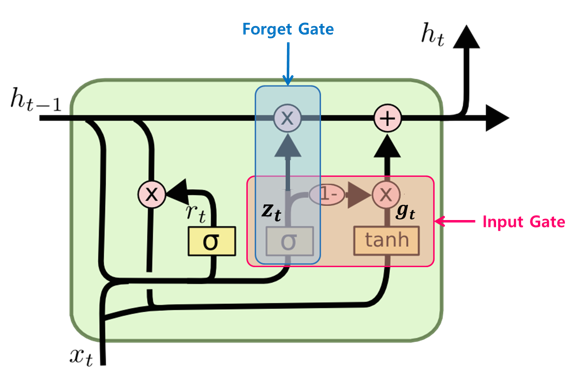

In [4]:
h_dim = 128  # hidden_dimension
input_size = len(word2index)  # Dimension of input meaning size of word2index
output_size = len(word2index)

## Repeat the above process using the previous hidden state and cell state for the next sequence after the corresponding process ✔

In [5]:
""" Make GRU Cell (class) """

class GRU_Cell(nn.Module):
  def __init__(self, input_size, h_dim):
    super(GRU_Cell, self).__init__()
    self.input_size = input_size
    self.h_dim = h_dim
    self.x2h = nn.Linear(input_size, 3 * h_dim)
    self.h2h = nn.Linear(h_dim, 3 * h_dim)

  def forward(self, x, hidden_state):
    x2gate = self.x2h(x)
    h2gate = self.h2h(hidden_state)

    x2r, x2u, x2c = x2gate.chunk(3,dim = 2)
    h2r, h2u, h2c = h2gate.chunk(3,dim = 2)

    reset_gate = torch.sigmoid(x2r + h2r)
    update_gate = torch.sigmoid(x2u + h2u)
    candidate = torch.tanh(x2c + reset_gate * h2c)
    
    new_hidden_state = candidate + torch.mul(update_gate,\
                                (hidden_state - candidate))
    
    return new_hidden_state

In [6]:
""" Make GRU with GRU Cell(class) """

class GRU(nn.Module):
  def __init__(self, input_size, h_dim, output_size):
    super(GRU, self).__init__()
    self.input_size = input_size
    self.h_dim = h_dim
    self.output_size = output_size
    self.gru = GRU_Cell(input_size, h_dim)
    self.fc = nn.Linear(h_dim, output_size)
  
  def forward(self, x, hidden_state=None):
    if hidden_state is not None:
      hidden_state = hidden_state
    else:
      hidden_state = torch.zeros((x.size(0),1,self.h_dim))

    hidden_state_total = list() ## For Seq2Seq with Attention
    outputs = list() 
    
    ## Use the for statement to proceed with the process for all sequence
    for seq in range(x.size(1)) :
      hidden_state = self.gru(x[:, seq, :].unsqueeze(1), hidden_state)
      outputs.append(hidden_state)
      hidden_state_total.append(hidden_state)

    outputs = torch.cat(outputs, dim=1)
    result = self.fc(outputs)

    return result, hidden_state_total

In [7]:
gru = GRU(input_size,h_dim,output_size)

In [8]:
result, hidden_state = gru(input)
print("Size of result :", result.size())
print("result :\n", result)

Size of result : torch.Size([1, 6, 42])
result :
 tensor([[[-0.0940, -0.0728,  0.1406,  0.0468, -0.0873,  0.0431, -0.0816,
          -0.0406, -0.0267, -0.0339, -0.1225,  0.0183, -0.0153,  0.0132,
           0.0239, -0.0638, -0.0778, -0.0864, -0.0807, -0.0359,  0.0773,
          -0.0567, -0.0091, -0.0519, -0.0351, -0.0311, -0.0613,  0.0473,
           0.0050, -0.0207, -0.0957,  0.0444,  0.0287, -0.0795,  0.0677,
          -0.0151,  0.0401, -0.0517,  0.0594,  0.0338, -0.0213,  0.0089],
         [-0.1147, -0.0275,  0.1849,  0.0341, -0.0957, -0.0006, -0.0755,
          -0.0147, -0.0368, -0.0365, -0.1626, -0.0349, -0.0400,  0.0774,
          -0.0070, -0.0666, -0.0658, -0.0811, -0.0601, -0.0651,  0.1042,
           0.0620, -0.0027, -0.0669, -0.0852, -0.0190, -0.0385,  0.0415,
          -0.0370, -0.0454, -0.1308,  0.0643,  0.0559, -0.1263,  0.0567,
          -0.0755,  0.0752, -0.0227,  0.1026,  0.0303, -0.0179,  0.0606],
         [-0.1248, -0.0453,  0.2194,  0.0501, -0.0629,  0.0333, -0.0596,